In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    measures_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'Lattice'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

def load_dataframes(net_type, sizes, param, attack, min_nseeds=None, nseeds=None):
    dfs = {}
    for size in sizes:
        try:
            dfs[size] = load_dataframe(net_type, size, param, attack, min_nseeds=min_nseeds, nseeds=nseeds)
        except FileNotFoundError:
            continue
    return dfs

In [2]:
measures = [
    'meanS','varSgcc', 'Nsec', #'Sgcc'
           ]
attacks = [
    'Ran'
]

sizes = [64, 91, 128, 181, 256, 362, 512]

#print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for size in sizes:
        try:
            dfs[size] = load_dataframe(net_type, size, param, attack, min_nseeds=10000)
        except FileNotFoundError:
            continue
    L_values = np.array(list(dfs.keys()))
    for i, measure in enumerate(measures):

        measure_values = get_critical_measures(
            dfs, measure, 
            fc='peak'
            #fc=0.5
            #fc=0.30324
            #fc=0.40731 
        )
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-3] / L_values[-3]**slope
        
        nu = 4/3
        if measure in ['Sgcc', 'Nsec']:
            beta_over_nu = 2 - slope
            delta_beta = y_err
            beta = beta_over_nu*nu
            beta_err = y_err*nu
            print(measure, 'beta = ', '{:.3f}+-{:.3f}'.format(beta, beta_err))
        elif measure in ['meanS', 'varSgcc']:
            gamma_over_nu = slope
            delta_gamma = y_err   
            gamma = gamma_over_nu*nu
            gamma_err = y_err*nu
            print(measure, 'gamma = ', '{:.3f}+-{:.3f}'.format(gamma, gamma_err))
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err, c]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    if False:
        print(
            '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
                attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
                2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(L_values)
            )
        )
        
print('beta_theo = {:.3f}'.format(5/36))
print('gamma_theo = {:.3f}'.format(43/18))

INFO: 06/19/2021 04:16:01 PM NumExpr defaulting to 4 threads.


meanS gamma =  2.276+-0.015
varSgcc gamma =  2.419+-0.015
Nsec beta =  0.153+-0.017
beta_theo = 0.139
gamma_theo = 2.389


2-beta_over_nu = 1.896
gamma_theo = 1.792


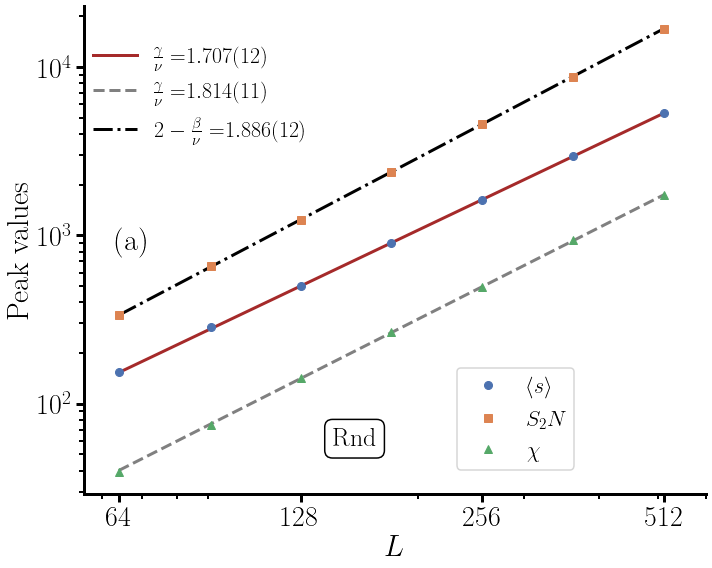

In [29]:
measures = [
    'meanS', 'Nsec', 'varSgcc', #'Sgcc'
           ]

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(56, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
    
for k, attack in enumerate(attacks):

    ax.text(0.05, 0.5, letters[k], transform=ax.transAxes, fontsize=30)
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.4, 0.1, attack_dict[attack], transform=ax.transAxes, fontsize=26, bbox=bbox)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$')

    for i, measure in enumerate(measures):

        L_values, measure_values, Y_pred, slope, y_err, c = data[attack][measure]    

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '-', color='brown', label=label)

        if measure == 'varSgcc':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)

        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)   
            
        elif measure == 'Sgcc':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), ':', color='C8', label=label)   

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [1, 3, 5, 7][:len(measures)]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.6, 0.05))

    ax.add_artist(legend1)
    ## Lines
    order = [0, 4, 2, 6][:len(measures)]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.0, 0.7), frameon=False)

print('2-beta_over_nu = {:.3f}'.format(2-(5/36) / (4/3)))
print('gamma_theo = {:.3f}'.format((43/18)/(4/3)))
sns.despine()
plt.tight_layout()
plt.show()

INFO: 06/22/2021 04:24:02 PM NumExpr defaulting to 4 threads.


meanS	gamma = 2.280+-0.018
num	gamma = 2.367+-0.020
num_over_denom	gamma = 2.229+-0.041
varSgcc	gamma = 2.418+-0.016


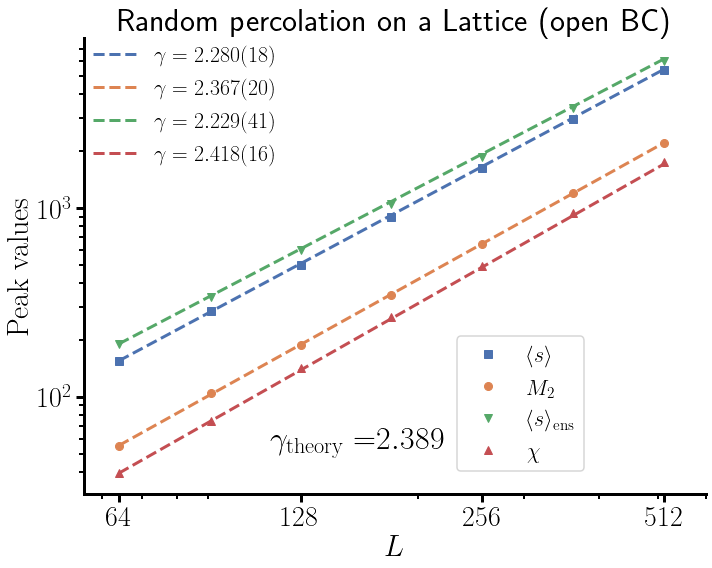

In [2]:
measures = [
    'meanS', 'num', 'num_over_denom', 'varSgcc',
]
net_type = 'Lattice'
attack = 'Ran'
min_nseeds = 10000
sizes = [64, 91, 128, 181, 256, 362, 512]

data = {}
dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds)
L_values = np.array(list(dfs.keys()))

for i, measure in enumerate(measures):

    measure_values = get_critical_measures(
        dfs, measure, 
        fc='peak'
    )
    Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
    c = measure_values[0] / L_values[0]**slope
    data[measure] = [measure_values, Y_pred, slope, y_err, c]

    nu = 4/3
    gamma_over_nu = slope
    delta_gamma = y_err   
    gamma = gamma_over_nu*nu
    gamma_err = y_err*nu
    print(f'{measure}\tgamma = {gamma:.3f}+-{gamma_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Random percolation on a Lattice (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(56, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):
    measure_values, Y_pred, slope, y_err, c = data[measure]        
    gamma = slope * (4/3)
    gamma_err = y_err * (4/3)
    label = r'$\gamma = {{{:.3f}}}({{{:.0f}}})$'.format(gamma, 1000*gamma_err)
    ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i}', label=label)
    ax.plot(L_values, measure_values, markers[i], color=f'C{i}', markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7][:len(measures)]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6][:len(measures)]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
text = r'$\gamma_{\mathrm{theory}} = $' + r'${{{:.3f}}}$'.format((43/18))
ax.text(0.3, 0.1, text, transform=ax.transAxes, fontsize=32)
sns.despine()
plt.tight_layout()
plt.show()

In [22]:
measures = [
    'meanS', 'num', 'num_over_denom', 'varSgcc',
]
net_type = 'DT'
attack = 'Btw'
min_nseeds = 10000
sizes = [16384, 32768, 65536, 131072]

data = {}
dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds)
L_values = np.sqrt(list(dfs.keys()))

for i, measure in enumerate(measures):

    measure_values = get_critical_measures(
        dfs, measure, 
        fc='peak'
    )
    Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
    c = measure_values[0] / L_values[0]**slope
    data[measure] = [measure_values, Y_pred, slope, y_err, c]

    nu = 4/3
    gamma_over_nu = slope
    delta_gamma = y_err   
    gamma = gamma_over_nu*nu
    gamma_err = y_err*nu
    print(f'{measure}\tgamma/nu = {gamma_over_nu:.3f}+-{y_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Btw percolation on a DT (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(56, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):
    measure_values, Y_pred, slope, y_err, c = data[measure]        
    label = r'$\gamma/\nu = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i}', label=label)
    ax.plot(L_values, measure_values, markers[i], color=f'C{i}', markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7][:len(measures)]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6][:len(measures)]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)

sns.despine()
plt.tight_layout()
plt.show()

meanS	gamma/nu = 1.935+-0.011


KeyError: 'num'

meanS	gamma/nu = 1.716+-0.030
num	gamma/nu = 1.796+-0.007
num_over_denom	gamma/nu = 1.678+-0.016
varSgcc	gamma/nu = 1.834+-0.023
gamma_theo = 1.792


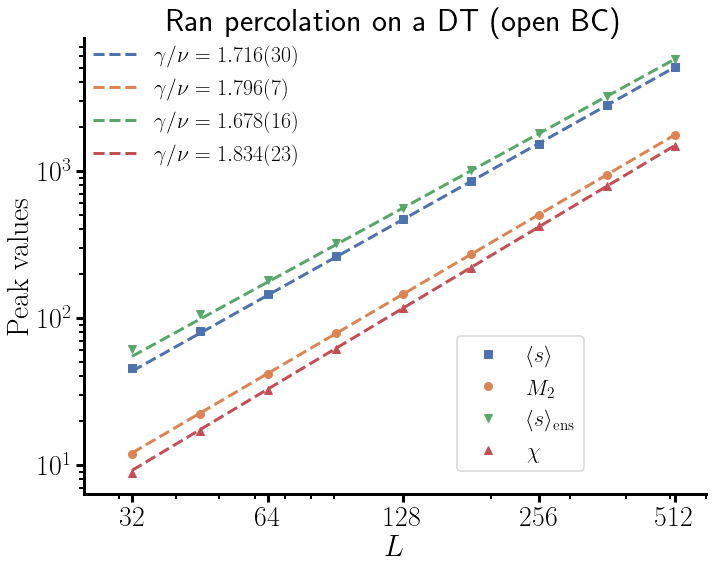

In [9]:
         
measures = [
    'meanS', 'num', 'num_over_denom', 'varSgcc',
]
net_type = 'DT'
#attack = 'Btw_cutoff2'
attack = 'Ran'
param = 'param'
nseeds = 10000
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144
]

data = {}
dfs = load_dataframes(net_type, sizes, param, attack, nseeds=nseeds)
L_values = np.sqrt(list(dfs.keys()))

for i, measure in enumerate(measures):

    measure_values = get_critical_measures(
        dfs, measure, 
        fc='peak',
        include_gcc=False
    )
    Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
    c = measure_values[-2] / L_values[-2]**slope
    data[measure] = [measure_values, Y_pred, slope, y_err, c]

    nu = 4/3
    gamma_over_nu = slope
    delta_gamma = y_err   
    gamma = gamma_over_nu*nu
    gamma_err = y_err*nu
    print(f'{measure}\tgamma/nu = {gamma_over_nu:.3f}+-{y_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Ran percolation on a DT (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(25, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):
    measure_values, Y_pred, slope, y_err, c = data[measure]        
    label = r'$\gamma/\nu = {{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
    ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i}', label=label)
    ax.plot(L_values, measure_values, markers[i], color=f'C{i}', markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7][:len(measures)]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6][:len(measures)]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
print('gamma_theo = {:.3f}'.format((43/18)/(4/3)))
sns.despine()
plt.tight_layout()
plt.show()

[  11.85180176   22.24492217   41.60537188   78.53770474  145.2354244
  271.13508998  502.87168237  940.04108529 1751.65302298]
num	gamma/nu = 1.796+-0.007
[  12.08330605   22.45345859   41.81287217   78.73863794  145.43499344
  271.32819277  503.04718339  940.22392824 1751.81899246]
num	gamma/nu = 1.795+-0.007
[  11.85180176   22.24492217   41.60537188   78.53770474  145.2354244
  271.13508998  502.87168237  940.04108529 1751.65302298]
num	gamma/nu = 1.796+-0.007
[  12.08330605   22.45345859   41.81287217   78.73863794  145.43499344
  271.32819277  503.04718339  940.22392824 1751.81899246]
num	gamma/nu = 1.795+-0.007
gamma_theo = 1.792


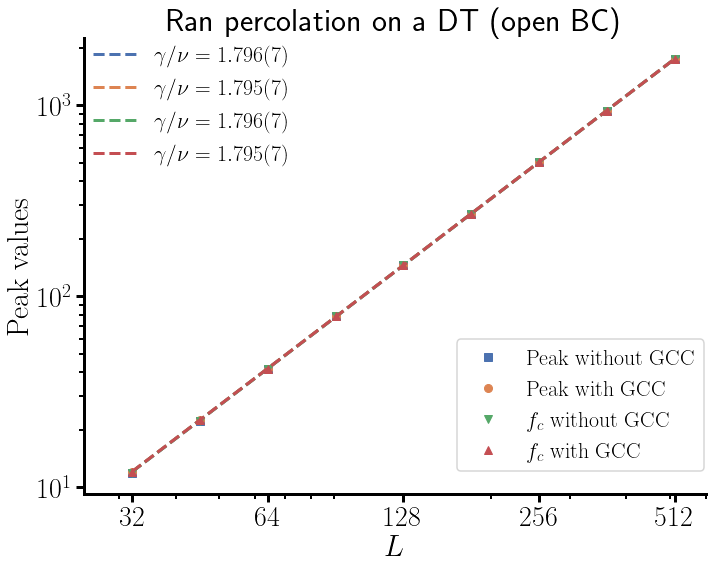

In [10]:
         
measure = 'num'
net_type = 'DT'
#attack = 'Btw_cutoff2'
attack = 'Ran'
param = 'param'
fc_ran = 0.5
nseeds = 10000
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144
]
labels = [
    r'$\mathrm{Peak\;without\;GCC}$',
    r'$\mathrm{Peak\;with\;GCC}$',
    r'$f_c\mathrm{\;without\;GCC}$',
    r'$f_c\mathrm{\;with\;GCC}$'
    
]
data = {}
dfs = load_dataframes(net_type, sizes, param, attack, nseeds=nseeds)
L_values = np.sqrt(list(dfs.keys()))
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):

        measure_values = get_critical_measures(
            dfs, measure, 
            fc='peak',
            include_gcc=include_gcc
        )
        print(measure_values)
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-2] / L_values[-2]**slope
        data[(include_gcc, fc)] = [measure_values, Y_pred, slope, y_err, c]

        nu = 4/3
        gamma_over_nu = slope
        delta_gamma = y_err   
        gamma = gamma_over_nu*nu
        gamma_err = y_err*nu
        print(f'{measure}\tgamma/nu = {gamma_over_nu:.3f}+-{y_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Ran percolation on a DT (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(25, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):
        measure_values, Y_pred, slope, y_err, c = data[(include_gcc, fc)]        
        label = r'$\gamma/\nu = {{{:.3f}}}({{{:.0f}}})$'.format(slope, 1000*y_err)
        ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i+2*k}', label=label)
        ax.plot(L_values, measure_values, markers[i+2*k], color=f'C{i+2*k}', markersize=8, label=labels[i+2*k])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
print('gamma_theo = {:.3f}'.format((43/18)/(4/3)))
sns.despine()
plt.tight_layout()
plt.show()

[  55.21827239  104.51476003  189.30087474  347.07361479  643.89321408
 1197.66717687 2210.28494538]
num	gamma/nu = 1.776+-0.015
[  55.45024292  104.75026485  189.52801558  347.28961284  644.09182878
 1197.85928761 2210.47619991]
num	gamma/nu = 1.775+-0.016
[  55.21827239  104.51476003  189.30087474  347.07361479  643.89321408
 1197.66717687 2210.28494538]
num	gamma/nu = 1.776+-0.015
[  55.45024292  104.75026485  189.52801558  347.28961284  644.09182878
 1197.85928761 2210.47619991]
num	gamma/nu = 1.775+-0.016
gamma_theo = 1.792


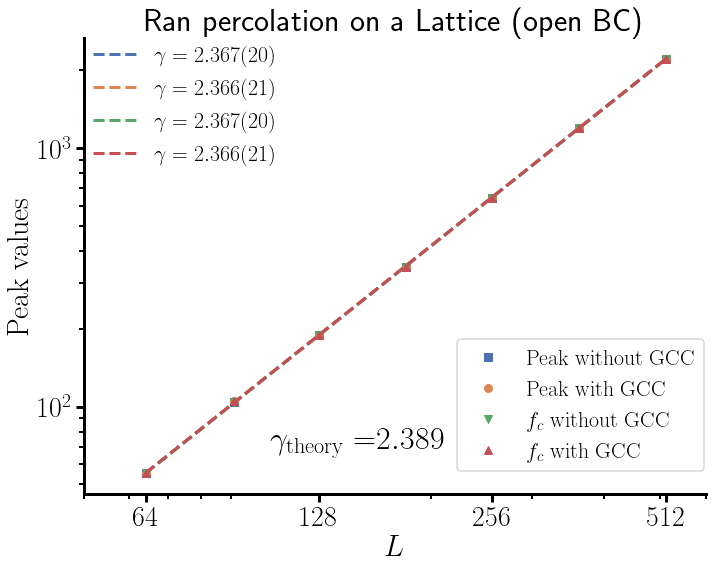

In [19]:
         
measure = 'num'
net_type = 'Lattice'
#attack = 'Btw_cutoff2'
attack = 'Ran'
param = 'param'
fc_ran = 1 - 0.59274605079
nseeds = 10000
sizes = [64, 91, 128, 181, 256, 362, 512]
labels = [
    r'$\mathrm{Peak\;without\;GCC}$',
    r'$\mathrm{Peak\;with\;GCC}$',
    r'$f_c\mathrm{\;without\;GCC}$',
    r'$f_c\mathrm{\;with\;GCC}$'
    
]
data = {}
dfs = load_dataframes(net_type, sizes, param, attack, nseeds=nseeds)
L_values = np.array(list(dfs.keys()))
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):

        measure_values = get_critical_measures(
            dfs, measure, 
            fc='peak',
            include_gcc=include_gcc
        )
        print(measure_values)
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-2] / L_values[-2]**slope
        data[(include_gcc, fc)] = [measure_values, Y_pred, slope, y_err, c]

        nu = 4/3
        gamma_over_nu = slope
        delta_gamma = y_err   
        gamma = gamma_over_nu*nu
        gamma_err = y_err*nu
        print(f'{measure}\tgamma/nu = {gamma_over_nu:.3f}+-{y_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Ran percolation on a Lattice (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(50, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):
        measure_values, Y_pred, slope, y_err, c = data[(include_gcc, fc)]    
        gamma = slope * (4/3)
        gamma_err = y_err * (4/3)
        label = r'$\gamma = {{{:.3f}}}({{{:.0f}}})$'.format(gamma, 1000*gamma_err)
        ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i+2*k}', label=label)
        ax.plot(L_values, measure_values, markers[i+2*k], color=f'C{i+2*k}', markersize=8, label=labels[i+2*k])  
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
text = r'$\gamma_{\mathrm{theory}} = $' + r'${{{:.3f}}}$'.format((43/18))
ax.text(0.3, 0.1, text, transform=ax.transAxes, fontsize=32)
print('gamma_theo = {:.3f}'.format((43/18)/(4/3)))
sns.despine()
plt.tight_layout()
plt.show()

[  11.85180176   22.24492217   41.60537188   78.53770474  145.2354244
  271.13508998  502.87168237  940.04108529 1751.65302298]
num	gamma/nu = 1.796+-0.007
[  12.08330605   22.45345859   41.81287217   78.73863794  145.43499344
  271.32819277  503.04718339  940.22392824 1751.81899246]
num	gamma/nu = 1.795+-0.007
[  11.85180176   22.24492217   41.60537188   78.53770474  145.2354244
  271.13508998  502.87168237  940.04108529 1751.65302298]
num	gamma/nu = 1.796+-0.007
[  12.08330605   22.45345859   41.81287217   78.73863794  145.43499344
  271.32819277  503.04718339  940.22392824 1751.81899246]
num	gamma/nu = 1.795+-0.007
gamma_theo = 1.792


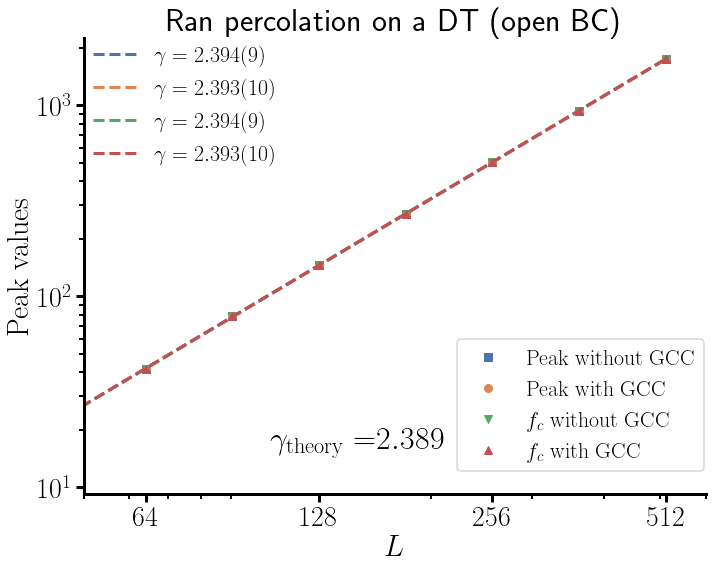

In [21]:
         
measure = 'num'
net_type = 'DT'
#attack = 'Btw_cutoff2'
attack = 'Ran'
param = 'param'
fc_ran = 0.5
nseeds = 10000
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144
]

labels = [
    r'$\mathrm{Peak\;without\;GCC}$',
    r'$\mathrm{Peak\;with\;GCC}$',
    r'$f_c\mathrm{\;without\;GCC}$',
    r'$f_c\mathrm{\;with\;GCC}$'
    
]
data = {}
dfs = load_dataframes(net_type, sizes, param, attack, nseeds=nseeds)
L_values = np.sqrt(list(dfs.keys()))
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):

        measure_values = get_critical_measures(
            dfs, measure, 
            fc='peak',
            include_gcc=include_gcc
        )
        print(measure_values)
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-2] / L_values[-2]**slope
        data[(include_gcc, fc)] = [measure_values, Y_pred, slope, y_err, c]

        nu = 4/3
        gamma_over_nu = slope
        delta_gamma = y_err   
        gamma = gamma_over_nu*nu
        gamma_err = y_err*nu
        print(f'{measure}\tgamma/nu = {gamma_over_nu:.3f}+-{y_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Ran percolation on a DT (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(50, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')
for k, fc in enumerate(['peak', fc_ran]):
    for i, include_gcc in enumerate([False, True]):
        measure_values, Y_pred, slope, y_err, c = data[(include_gcc, fc)]    
        gamma = slope * (4/3)
        gamma_err = y_err * (4/3)
        label = r'$\gamma = {{{:.3f}}}({{{:.0f}}})$'.format(gamma, 1000*gamma_err)
        ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i+2*k}', label=label)
        ax.plot(L_values, measure_values, markers[i+2*k], color=f'C{i+2*k}', markersize=8, label=labels[i+2*k])  
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
text = r'$\gamma_{\mathrm{theory}} = $' + r'${{{:.3f}}}$'.format((43/18))
ax.text(0.3, 0.1, text, transform=ax.transAxes, fontsize=32)
print('gamma_theo = {:.3f}'.format((43/18)/(4/3)))
sns.despine()
plt.tight_layout()
plt.show()

## Estimation of $\beta$

INFO: 06/22/2021 04:45:48 PM NumExpr defaulting to 4 threads.


Nsec	beta = 0.153+-0.017
Sgcc	beta = 0.162+-0.128
Nsec	beta = 0.148+-0.003
Sgcc	beta = 0.148+-0.014


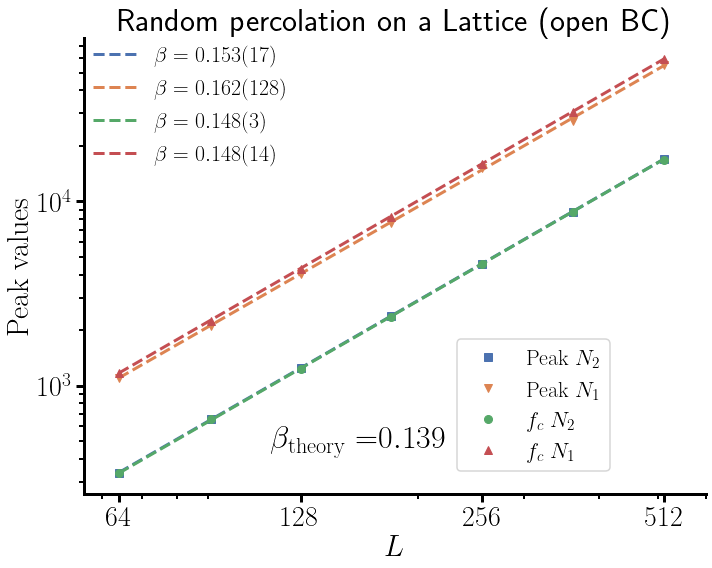

In [2]:
measures = [
    'Nsec', 'Sgcc'
]
net_type = 'Lattice'
attack = 'Ran'
min_nseeds = 10000
sizes = [64, 91, 128, 181, 256, 362, 512]
fc_ran = 1 - 0.59274605079
data = {}
dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds)
L_values = np.array(list(dfs.keys()))

for fc in ['peak', fc_ran]:
    for measure in measures:
        measure_values = get_critical_measures(dfs, measure, fc=fc)
        #print(fc, measure, measure_values)
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[0] / L_values[0]**slope
        data[(measure, fc)] = [measure_values, Y_pred, slope, y_err, c]

        nu = 4/3
        beta_over_nu = 2-slope
        delta_beta = y_err   
        beta = beta_over_nu*nu
        beta_err = y_err*nu
        print(f'{measure}\tbeta = {beta:.3f}+-{beta_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Random percolation on a Lattice (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(56, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

labels = [
    r'$\mathrm{Peak\;}N_2$',
    r'$\mathrm{Peak\;}N_1$',
    r'$f_c\; N_2$',
    r'$f_c\;N_1$'
    
]
for j, fc in enumerate(['peak', fc_ran]):
    for i, measure in enumerate(measures):
        measure_values, Y_pred, slope, y_err, c = data[(measure, fc)]
        beta = (2-slope) * (4/3)
        beta_err = y_err * (4/3)
        label = r'$\beta = {{{:.3f}}}({{{:.0f}}})$'.format(beta, 1000*beta_err)
        ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i+2*j}', label=label)
        ax.plot(L_values, measure_values, markers[j+2*i], color=f'C{i+2*j}', markersize=8, label=labels[i+2*j])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
text = r'$\beta_{\mathrm{theory}} = $' + r'${{{:.3f}}}$'.format((5/36))
ax.text(0.3, 0.1, text, transform=ax.transAxes, fontsize=32)
sns.despine()
plt.tight_layout()
plt.show()

Nsec	beta = 0.141+-0.023
Sgcc	beta = 0.166+-0.148
Nsec	beta = 0.156+-0.011
Sgcc	beta = 0.140+-0.023


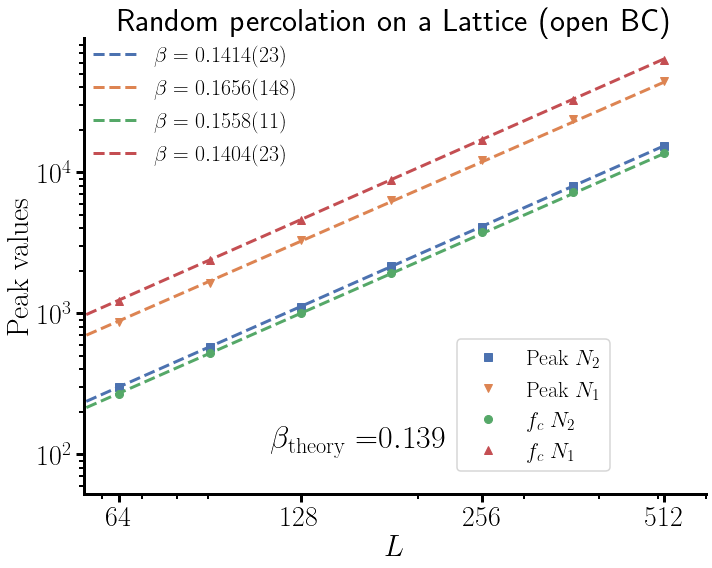

In [5]:
measures = [
    'Nsec', 'Sgcc'
]
net_type = 'DT'
attack = 'Ran'
min_nseeds = 10000
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144
]
fc_ran = 0.5
data = {}
dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds)
L_values = np.sqrt(list(dfs.keys()))

for fc in ['peak', fc_ran]:
    for measure in measures:
        measure_values = get_critical_measures(dfs, measure, fc=fc)
        #print(fc, measure, measure_values)
        Y_pred, slope, y_err = getLinearReg(L_values[-4:], measure_values[-4:])
        c = measure_values[0] / L_values[0]**slope
        data[(measure, fc)] = [measure_values, Y_pred, slope, y_err, c]

        nu = 4/3
        beta_over_nu = 2-slope
        delta_beta = y_err   
        beta = beta_over_nu*nu
        beta_err = y_err*nu
        print(f'{measure}\tbeta = {beta:.3f}+-{beta_err:.3f}')

###############################################################################    

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Random percolation on a Lattice (open BC)', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(56, 600)
ax.set_xticks([64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

labels = [
    r'$\mathrm{Peak\;}N_2$',
    r'$\mathrm{Peak\;}N_1$',
    r'$f_c\; N_2$',
    r'$f_c\;N_1$'
    
]
for j, fc in enumerate(['peak', fc_ran]):
    for i, measure in enumerate(measures):
        measure_values, Y_pred, slope, y_err, c = data[(measure, fc)]
        beta = (2-slope) * (4/3)
        beta_err = y_err * (4/3)
        label = r'$\beta = {{{:.3f}}}({{{:.0f}}})$'.format(beta, 1000*beta_err)
        ax.plot(L_values, powerlaw(L_values, slope, c), '--', color=f'C{i+2*j}', label=label)
        ax.plot(L_values, measure_values, markers[j+2*i], color=f'C{i+2*j}', markersize=8, label=labels[i+2*j])
    
handles, labels = ax.get_legend_handles_labels()

## Markers
order = [1, 3, 5, 7]
legend1 = ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.6, 0.05)
)
ax.add_artist(legend1)

## Lines
order = [0, 2, 4, 6]
ax.legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    fontsize=22, loc=(0.0, 0.7), frameon=False
)
text = r'$\beta_{\mathrm{theory}} = $' + r'${{{:.3f}}}$'.format((5/36))
ax.text(0.3, 0.1, text, transform=ax.transAxes, fontsize=32)
sns.despine()
plt.tight_layout()
plt.show()

# $$N n_s = \text{# comp tamano s}$$

# $$N n_s s = \text{# nodos q pertenecen a comp de tamano s}$$

# $$p_s = n_s s$$

# $$S = \langle s \rangle_{p_s} \neq \dfrac{\sum_s n_s s}{\text{ # clusters}}$$

# $$ S = \dfrac{\sum_s n_s s^2}{\sum_s n_s s} = \dfrac{\sum_s (N n_s) s^2}{\sum_s (N n_s) s} = \dfrac{\sum_s (N n_s) s^2}{n-N_1}$$

# $$N_1 + \sum_s Nn_s s = n$$

# ahi vuelvo

In [2]:
Params = namedtuple('Param', ['fmin', 'fmax', 'ymin', 'ymax'])

attack_params = {
    'Ran': Params(0.4, 0.41, 2, 6),
}

16384
32761
65536
131044
262144
Ran                 0.40735 +- 0.00016  0.000405
1.1913976020388453 711.9690439395968
1.1874235040649836 626.2016545756095
1.1872820401546784 580.948998335933
1.1875692434410696 548.4883618781801
1.187372031618342 539.4264525265386


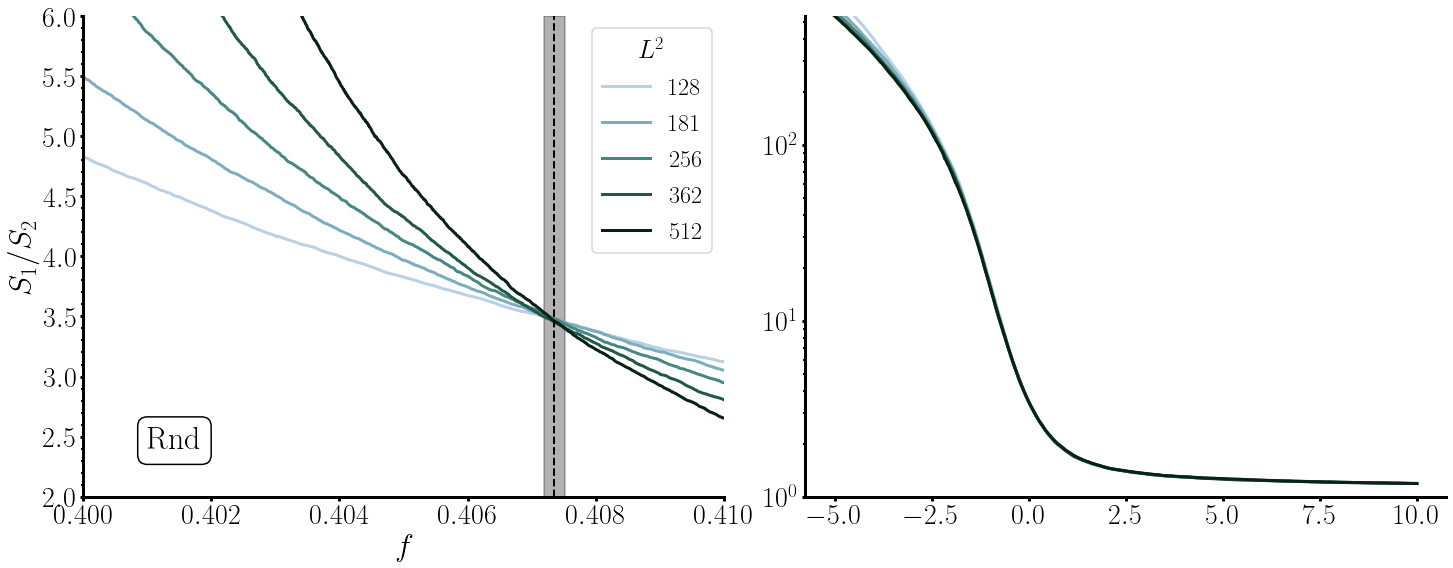

In [23]:
def plot_S1_over_S2(net_type, attacks):
    
    ncols = 2
    nrows = 1
    fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [
            64, 91, 128, 181, 256, 362, 512
        ]  
        
        dfs = {}
        for size in sizes:
            try:
                df = load_dataframe(net_type, size, param, attack, min_nseeds=10000)
                dfs[size] = df
            except FileNotFoundError:
                continue

        L_values = np.sort(list(dfs.keys()))[-5:]
        dfs = {L: dfs[L] for L in L_values}
        
        ax = axes[0]
        fmin, fmax, ymin, ymax = attack_params[attack]
        ax.set_xlim(fmin, fmax)
        ax.set_ylim(ymin, ymax)
        if (j % ncols) == 0:
            ax.set_ylabel(r'$S_1/S_2$', fontsize=32)
        if j >= ncols*(nrows-1):
            ax.set_xlabel(r'$f$', fontsize=32)

        colors = sns.cubehelix_palette(
            len(L_values), start=2, rot=0.3, 
            light=0.8, dark=0.1
        )
        for i, L in enumerate(L_values):
            df = dfs[L]
            S1_over_S2 = L*L * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(L), color=colors[i])
        
        if not dfs: ## Dict is empty
            continue

        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False, method='beta')
        
        fc_values[attack] = (mean_fc, std_fc)
    
        print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.1, attack_dict[attack], fontsize=32, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        legend = ax.legend(loc='best', fontsize=24)
        legend.set_title(r'$L^2$', prop={'size':26})
        
        nu = 4/3
        for i, L in enumerate(L_values):
            df = dfs[L]
            S1_over_S2 = L*L * df.Sgcc / df.Nsec
            ax = axes[1]
            #ax.set_xlim(-5,2)
            #ax.set_ylim(0, 1)
            X = (df.f-mean_fc)*L**(1/nu)
            Y = S1_over_S2
            mask = (X>-5) & (X<10)
            X = X[mask]
            Y = Y[mask]
            ax.set_ylim(1, np.nanmax(Y))
            ax.plot(X, Y, '-', label=r'${{{}}}$'.format(L), color=colors[i])
            ax.set_yscale('log')
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return fc_values, dfs
    
attacks = ['Ran']
fc_values, dfs = plot_S1_over_S2(net_type, attacks)

In [27]:
fc, err = 1-fc_values['Ran'][0], fc_values['Ran'][1]
print(f'{fc:.5f}+-{err:.5f}')

0.59285+-0.00017


In [2]:
size = 128
attack = 'Ran'
df = load_dataframe(net_type, size, param, attack, min_nseeds=10000)
df.shape

(16384, 8)


(16384, 8)

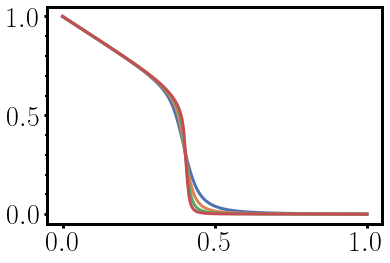

In [19]:
sizes = [64, 128, 256, 512]
for size in sizes:
    df = dfs[size]
    plt.plot(df.f, df.Sgcc)

In [24]:
attack = 'Ran'    
sizes = [64, 128, 256, 512]
dfs = {}
for size in sizes:
    try:
        df = load_dataframe(net_type, size, param, attack, min_nseeds=10000)
        dfs[size] = df
    except FileNotFoundError:
        continue
L_values = np.sort(list(dfs.keys()))
dfs = {L: dfs[L] for L in L_values}

fmin, fmax, ymin, ymax = attack_params[attack]        
mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False, method='beta')
mean_fc

4096
16384
65536
262144


0.40728866577148437

In [16]:
np.nanmax([1, np.nan])

1.0